In [73]:
# baseline cnn model for mnist
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.optimizers import Adam

import math


In [74]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = tf.keras.datasets.mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm


trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)

In [64]:
# Plotting data samples
# print('\n Plot of the first 25 samples in the MNIST training set')
# numbers_to_display = 3
# num_cells = math.ceil(math.sqrt(numbers_to_display))
# plt.figure(figsize=(10,10))
# for i in range(numbers_to_display):
#     plt.subplot(num_cells, num_cells, i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(trainX[i], cmap=plt.cm.binary)
#     plt.xlabel(trainY[i])
# plt.show()

In [75]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	#variable_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.2, patience = 2)
	#opt = SGD(variable_learning_rate, momentum=0.9)
	opt = SGD(learning_rate=0.05, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
model = define_model()
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_33 (Flatten)        (None, 1600)              0         
                                                                 
 dropout_18 (Dropout)        (None, 1600)            

In [76]:
# get ready for your first training run.
import datetime
import os
#%reload_ext tensorboard


logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0005)

model.fit(
    trainX,
    trainY,
    epochs=10,
    batch_size=70,
    validation_data=(testX, testY),
    callbacks=[tensorboard_callback, reduce_lr]
)


Epoch 1/10
858/858 [==============================] - 42s 48ms/step - loss: 0.1847 - accuracy: 0.9418 - val_loss: 0.0481 - val_accuracy: 0.9850 - lr: 0.0500
Epoch 2/10
858/858 [==============================] - 41s 48ms/step - loss: 0.0759 - accuracy: 0.9762 - val_loss: 0.0380 - val_accuracy: 0.9871 - lr: 0.0500
Epoch 3/10
858/858 [==============================] - 42s 49ms/step - loss: 0.0600 - accuracy: 0.9813 - val_loss: 0.0403 - val_accuracy: 0.9870 - lr: 0.0500
Epoch 4/10
858/858 [==============================] - 43s 50ms/step - loss: 0.0411 - accuracy: 0.9870 - val_loss: 0.0245 - val_accuracy: 0.9915 - lr: 0.0250
Epoch 5/10
858/858 [==============================] - 45s 53ms/step - loss: 0.0362 - accuracy: 0.9881 - val_loss: 0.0253 - val_accuracy: 0.9921 - lr: 0.0250
Epoch 6/10
858/858 [==============================] - 45s 53ms/step - loss: 0.0280 - accuracy: 0.9906 - val_loss: 0.0226 - val_accuracy: 0.9926 - lr: 0.0125
Epoch 7/10
858/858 [==============================] - 44s 

In [77]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	n_folds = 5 
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	fold_count = 1 
	es_callbacks = keras.callbacks.EarlyStopping(monitor="val_loss",
                                          mode="min",
                                          verbose=1,
                                          patience=4)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		print("="*80)
		print("Fold-{}".format(fold_count))
		print("-"*80)
		print("Training & Validation")
		fold_count = fold_count + 1
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), callbacks=[es_callbacks] )
		# evaluate model
		print("-"*80)
		print("Testing/evaluation")
		acc = model.evaluate(testX, testY)
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

scores, histories = evaluate_model(trainX, trainY)

Fold-1
--------------------------------------------------------------------------------
Training & Validation
Epoch 1/10
1500/1500 [==============================] - 41s 27ms/step - loss: 0.2510 - accuracy: 0.9236 - val_loss: 0.0921 - val_accuracy: 0.9712
Epoch 2/10
1500/1500 [==============================] - 58s 38ms/step - loss: 0.1365 - accuracy: 0.9613 - val_loss: 0.0770 - val_accuracy: 0.9778
Epoch 3/10
1500/1500 [==============================] - 69s 46ms/step - loss: 0.1107 - accuracy: 0.9684 - val_loss: 0.0773 - val_accuracy: 0.9806
Epoch 4/10
1500/1500 [==============================] - 69s 46ms/step - loss: 0.1072 - accuracy: 0.9696 - val_loss: 0.0671 - val_accuracy: 0.9818
Epoch 5/10
1500/1500 [==============================] - 82s 55ms/step - loss: 0.0943 - accuracy: 0.9734 - val_loss: 0.0648 - val_accuracy: 0.9827
Epoch 6/10
1500/1500 [==============================] - 102s 68ms/step - loss: 0.0941 - accuracy: 0.9747 - val_loss: 0.0585 - val_accuracy: 0.9834
Epoch 7/10
15

KeyboardInterrupt: 

In [69]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

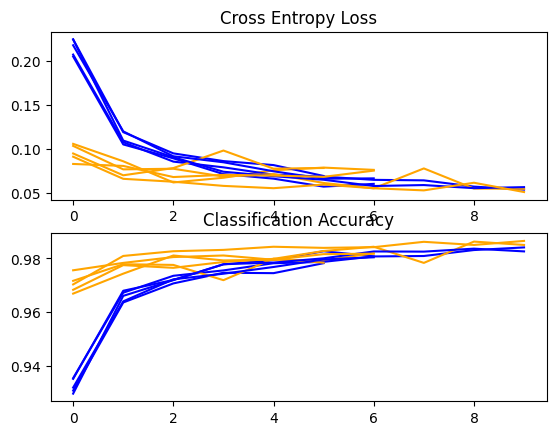

In [71]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	#scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)	
	# summarize estimated performance	
	#summarize_performance(scores)

# entry point, run the test harness
run_test_harness()